This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [ ]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
import tqdm
from cellpose import core, models
from skimage import io

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))

from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

## parse args and set paths

If if a notebook run the hardcoded paths.
However, if this is run as a script, the paths are set by the parsed arguments.

In [2]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        window_size=window_size,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    window_size = 3
    clip_limit = 0.05
    input_subparent_name = "deconvolved_images"
    mask_subparent_name = "deconvolved_segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
# get the nuclei image
for f in files:
    if "405" in f:
        nuclei = read_zstack_image(f)  # uses tifffile on the backend
nuclei = np.array(nuclei)
imgs = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)
original_imgs = imgs
print("Subsampled image shape:", imgs.shape)
print("number of z-slices:", imgs.shape[0])
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

Subsampled image shape: (33, 1537, 1540)
number of z-slices: 33
number of z slices in the original image: 33


In [5]:
# make a 2.5 D max projection image stack with a sliding window of 3 slices
image_stack_2_5D = np.empty((0, imgs.shape[1], imgs.shape[2]), dtype=imgs.dtype)
for image_index in range(imgs.shape[0]):
    image_stack_window = imgs[image_index : image_index + window_size]
    if not image_stack_window.shape[0] == window_size:
        break
    # max project the image stack
    image_stack_2_5D = np.append(
        image_stack_2_5D, np.max(image_stack_window, axis=0)[np.newaxis, :, :], axis=0
    )

imgs = np.array(image_stack_2_5D)
print("2.5D image stack shape:", image_stack_2_5D.shape)

2.5D image stack shape: (31, 1537, 1540)


## Cellpose

In [6]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "nuclei"

model = models.CellposeModel(
    gpu=use_GPU,
    model_type=model_name,
)

output_dict = {
    "slice": [],
    "labels": [],
    "details": [],
}
for slice in tqdm.tqdm(range(imgs.shape[0])):
    # Perform segmentation
    output_dict["slice"].append(slice)
    labels, details, _ = model.eval(imgs[slice, :, :], channels=[0, 0], diameter=100)
    output_dict["labels"].append(labels)
    output_dict["details"].append(details)

  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


## Reverse the sliding window max projection

In [7]:
# reverse sliding window max projection
full_mask_z_stack = []
reconstruction_dict = {index: [] for index in range(original_z_slice_count)}
print(f"Decoupling the sliding window max projection of {window_size} slices")

# loop through the sliding window max projected masks and decouple them
for z_stack_mask_index in range(len(output_dict["labels"])):
    z_stack_decouple = []
    # make n copies of the mask for sliding window decoupling
    # where n is the size of the sliding window
    [
        z_stack_decouple.append(output_dict["labels"][z_stack_mask_index])
        for _ in range(window_size)
    ]
    for z_window_index, z_stack_mask in enumerate(z_stack_decouple):
        # append the masks to the reconstruction_dict
        if not (z_stack_mask_index + z_window_index) >= original_z_slice_count:
            reconstruction_dict[z_stack_mask_index + z_window_index].append(
                z_stack_mask
            )

# save the reconstruction_dict to a file for downstream decoupling
np.save(mask_path / "nuclei_reconstruction_dict.npy", reconstruction_dict)

Decoupling the sliding window max projection of 3 slices


<Figure size 1000x500 with 0 Axes>

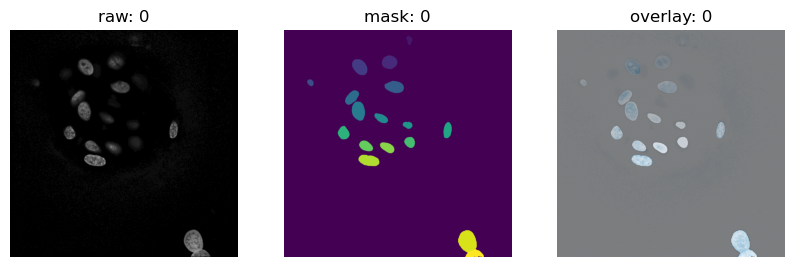

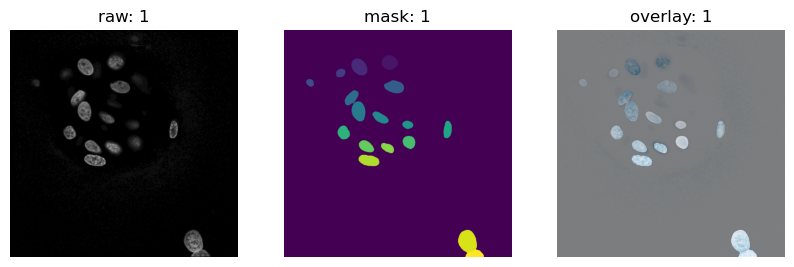

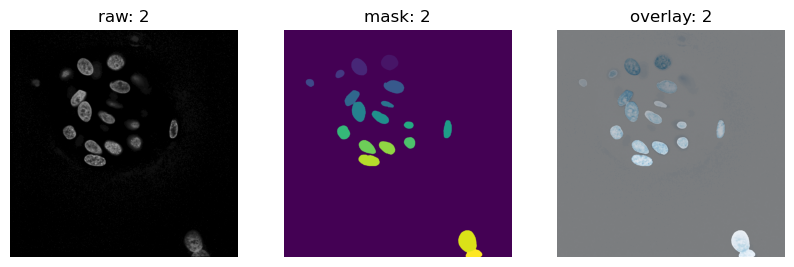

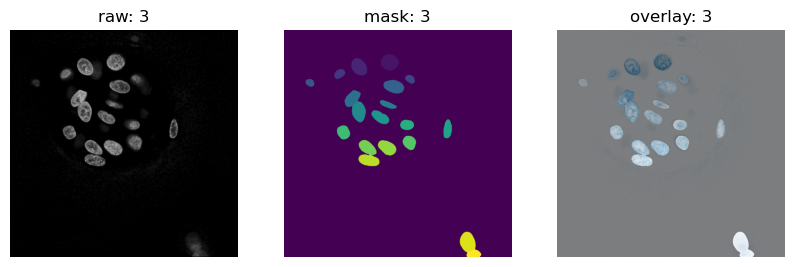

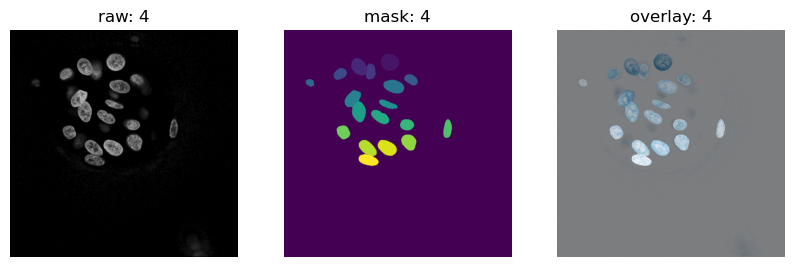

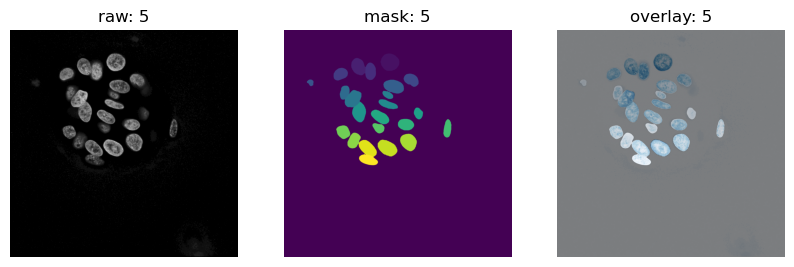

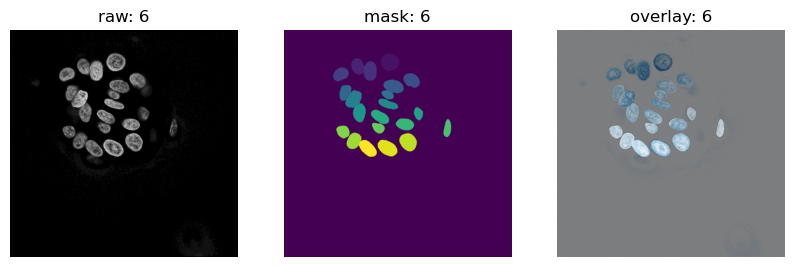

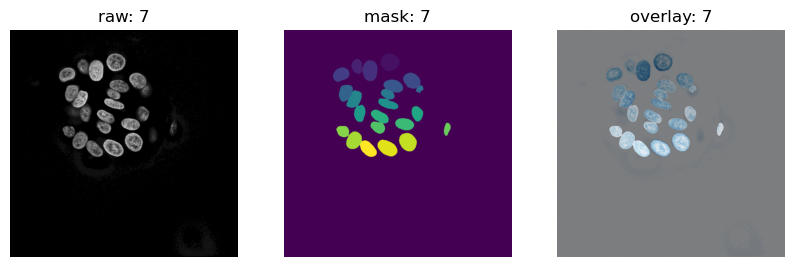

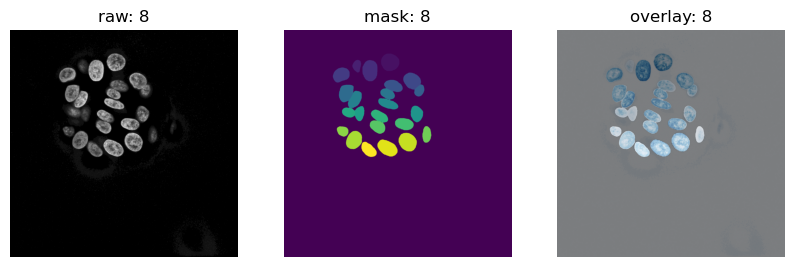

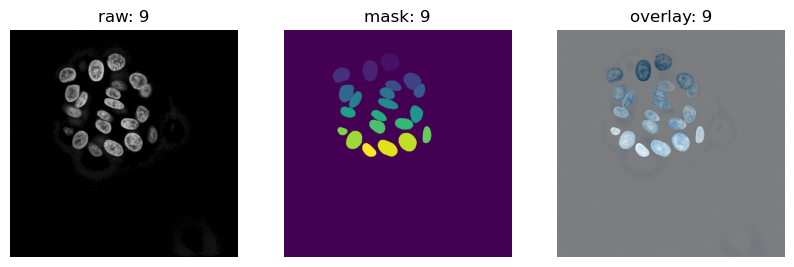

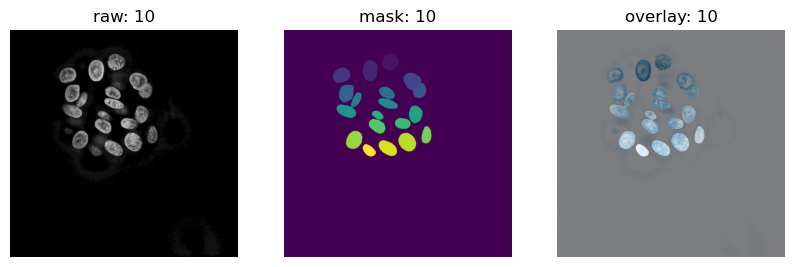

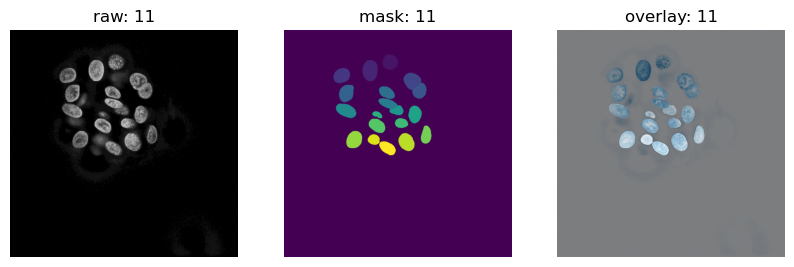

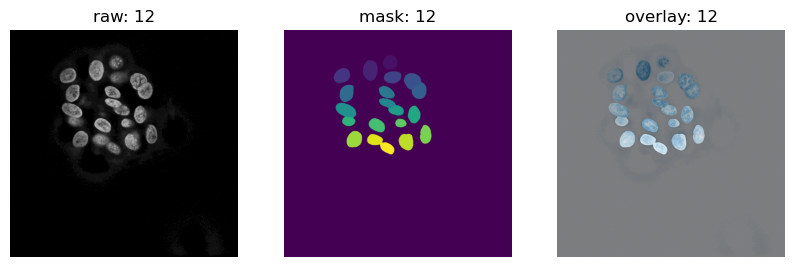

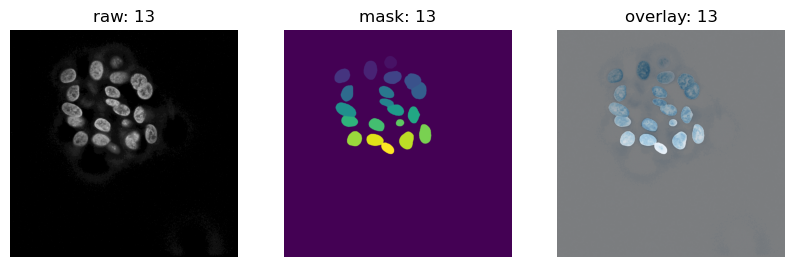

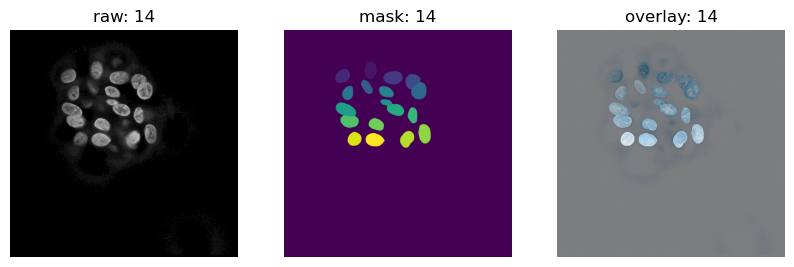

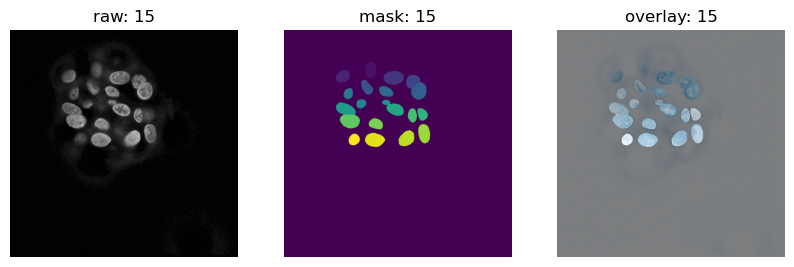

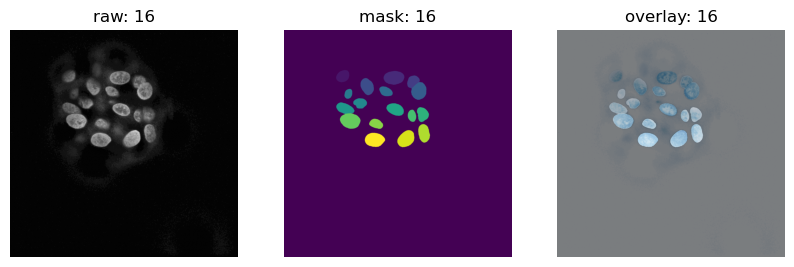

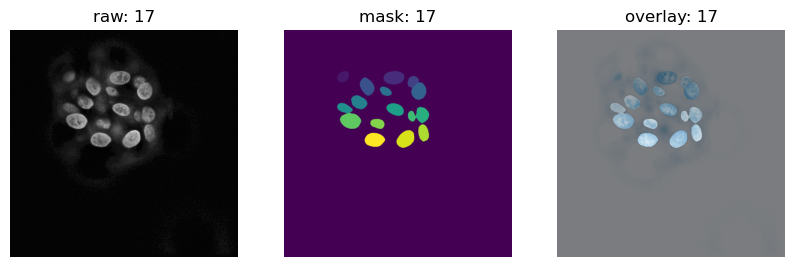

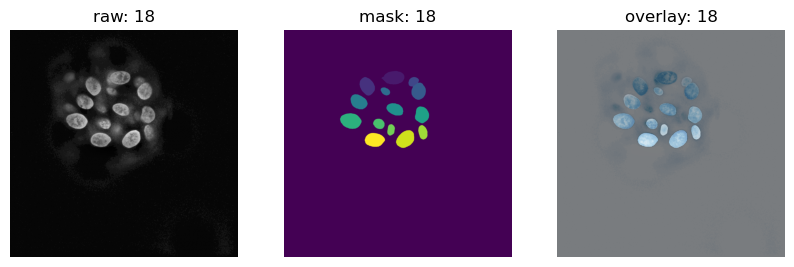

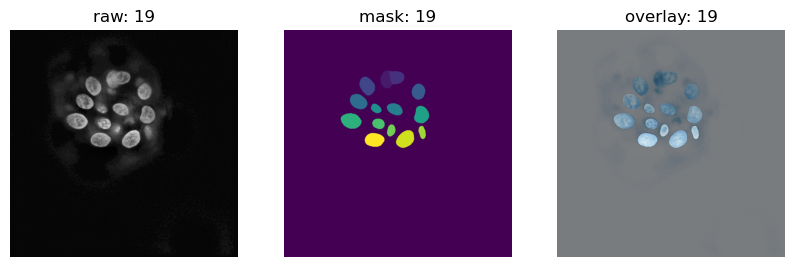

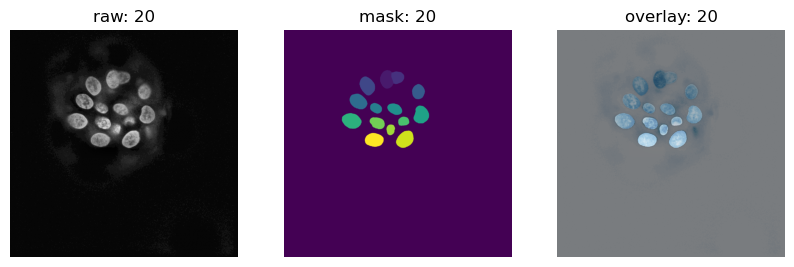

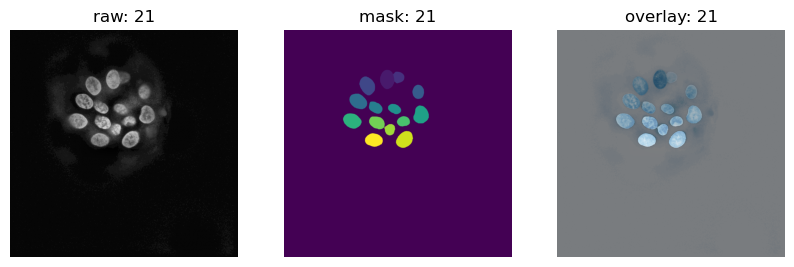

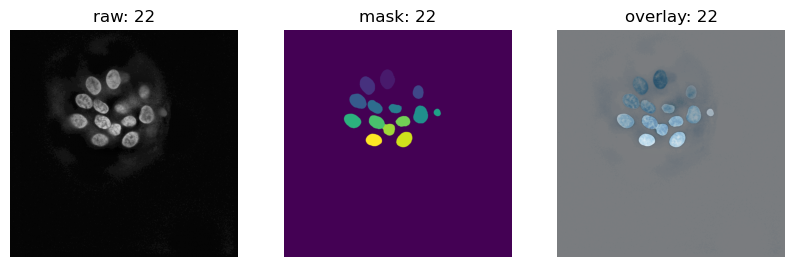

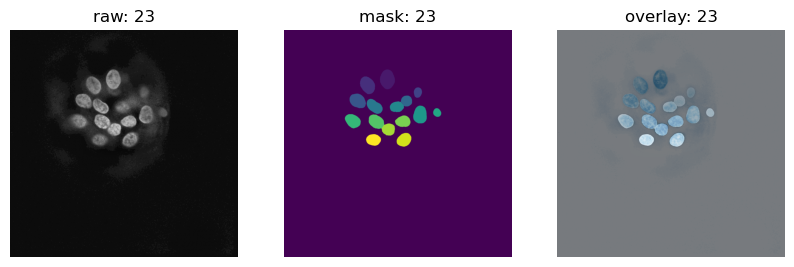

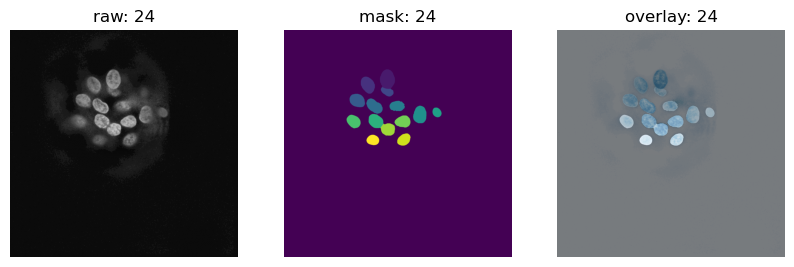

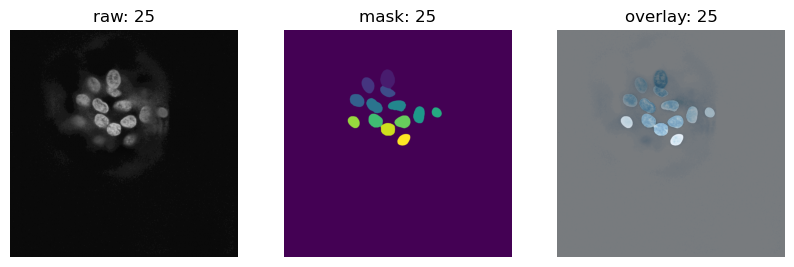

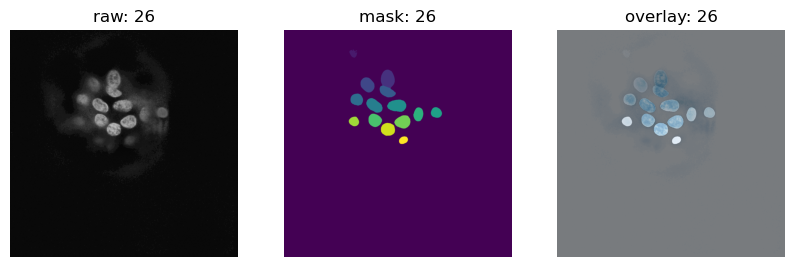

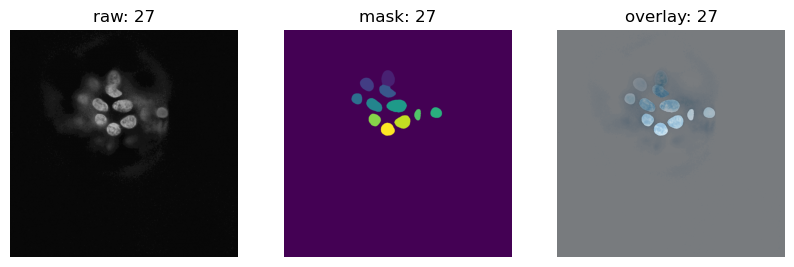

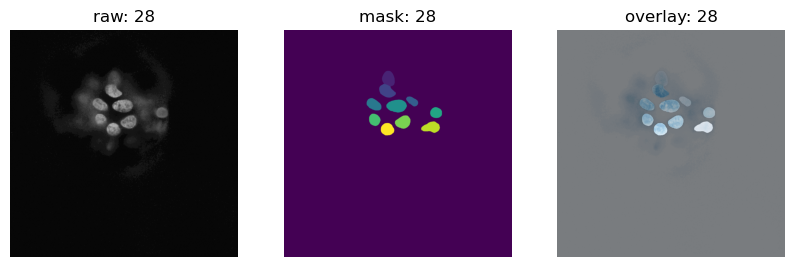

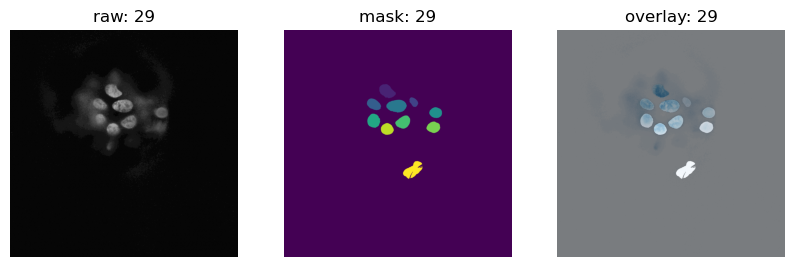

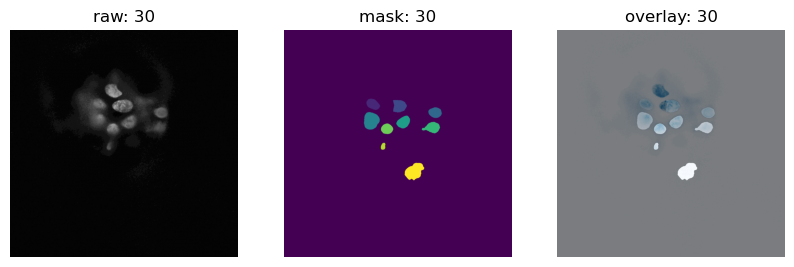

In [8]:
if in_notebook:
    plot = plt.figure(figsize=(10, 5))
    for z in range(len(output_dict["labels"])):
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.imshow(imgs[z], cmap="gray")
        plt.title(f"raw: {z}")
        plt.axis("off")

        plt.subplot(132)
        plt.imshow(output_dict["labels"][z])
        plt.title(f"mask: {z}")
        plt.axis("off")

        plt.subplot(133)
        plt.imshow(imgs[z], cmap="Blues")
        plt.imshow(output_dict["labels"][z], alpha=0.5, cmap="gray")
        plt.title(f"overlay: {z}")
        plt.axis("off")
        plt.show()